# Spectral Clustering: DAX network 

In this notebook, we employ spectral clustering to optimize clustering of the stocks in the German stock index 'DAX'. Nodes are representing the stocks in the DAX, edges reflect the correlation coefficient of the stocks' respective prices. 

# Step 0: Environment Setup

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import json

# Two helper functions
from same_cluster import *

# Step 1: Retrieving Stock Prices

In [2]:
# The stock tickers

DAX = ['1COV.DE', 'ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BMW.DE', 'CON.DE', 'DAI.DE',
        'DB1.DE', 'DBK.DE', 'DHER.DE', 'DPW.DE', 'DTE.DE', 'DWNI.DE', 'ENR.DE', 'EOAN.DE', 
      'FME.DE', 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LIN.DE', 'MRK.DE', 'MTX.DE', 
      'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'VNA.DE', 'VOW3.DE']

In [3]:
dax_df = yf.download(tickers=DAX, start='2016-01-01', end='2021-06-01',
                    auto_adjust = True, progress= False)

In [4]:
# That seems to have worked out well. 
dax_df['Close']

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DAI.DE,DB1.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW3.DE
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,25.334206,79.457558,117.340164,48.071789,86.740585,69.801834,175.963272,54.684761,67.778183,18.408138,...,12.162127,64.061958,78.963379,79.682495,136.519394,8.919367,63.608166,70.046715,22.204044,110.855713
2016-01-05,25.042156,79.185257,117.716232,47.801472,86.896805,69.476456,177.066620,54.677338,67.569710,18.704214,...,12.022867,NaN,80.310753,79.935959,136.059601,9.107920,64.374191,70.488968,22.352850,106.470596
2016-01-06,24.812414,78.268517,118.092346,47.004787,85.647041,67.176216,171.468170,53.288685,66.727150,18.549742,...,11.651505,NaN,79.192505,79.148376,136.442780,9.153008,64.932961,70.210510,21.890347,104.278030
2016-01-07,23.986891,77.052231,115.647751,45.859547,83.459976,64.648979,167.299973,51.239120,65.137581,18.150684,...,11.363699,NaN,76.662758,77.419296,133.913925,8.902970,64.293091,68.867409,21.480131,100.857643
2016-01-08,23.433945,75.745178,114.181000,45.297592,81.155746,63.135654,165.747101,50.637615,64.616409,17.562824,...,11.075892,NaN,76.176964,76.622650,132.457916,8.722616,64.031731,68.392395,21.138283,100.945351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,55.980000,299.149994,215.350006,67.110001,55.259998,85.769997,118.800003,76.639999,137.149994,12.270000,...,32.384998,244.894073,147.899994,208.000000,236.399994,32.279999,115.080002,135.380005,48.910000,214.488632
2021-05-26,55.720001,297.049988,214.100006,66.750000,54.970001,86.320000,119.440002,77.540001,136.600006,12.128000,...,32.160000,243.350723,147.250000,205.000000,233.699997,32.009998,116.019997,134.699997,49.650002,215.856033
2021-05-27,56.900002,297.250000,215.350006,66.370003,52.200001,87.680000,121.440002,77.870003,133.600006,12.250000,...,32.439999,245.591064,144.949997,210.000000,233.300003,31.120001,113.919998,130.020004,51.240002,220.104797


In [5]:
# Some of the companies have not been reported fully. 
dax_df['Close'].isna().sum()

1COV.DE       0
ADS.DE        0
ALV.DE        0
BAS.DE        0
BAYN.DE       0
BMW.DE        0
CON.DE        0
DAI.DE        0
DB1.DE        0
DBK.DE        0
DHER.DE     381
DPW.DE        0
DTE.DE        0
DWNI.DE       0
ENR.DE     1202
EOAN.DE       0
FME.DE        0
FRE.DE        0
HEI.DE        0
HEN3.DE       0
IFX.DE        0
LIN.DE      697
MRK.DE        0
MTX.DE        0
MUV2.DE       0
RWE.DE        0
SAP.DE        0
SIE.DE        0
VNA.DE        0
VOW3.DE       0
dtype: int64

# Step 2: Getting Correlation Matrix, Creating Graph

In [6]:
corr_mat = dax_df['Close'].corr()
corr_mat

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DAI.DE,DB1.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW3.DE
1COV.DE,1.000000,0.044881,0.235604,0.914736,0.427388,0.791682,0.632670,0.684555,-0.067387,0.408979,...,0.531865,0.312644,0.048915,0.062913,-0.068634,-0.034345,-0.009352,0.562199,-0.011612,0.416864
ADS.DE,0.044881,1.000000,0.906946,-0.012564,-0.652434,0.073748,-0.609942,-0.000069,0.906812,-0.659414,...,0.660794,0.810124,0.734204,0.884815,0.935730,0.904961,0.883185,0.593351,0.899772,0.690476
ALV.DE,0.235604,0.906946,1.000000,0.196962,-0.460825,0.297527,-0.390649,0.176437,0.837978,-0.484036,...,0.692849,0.674054,0.604772,0.916535,0.899146,0.791049,0.811009,0.644513,0.787531,0.826602
BAS.DE,0.914736,-0.012564,0.196962,1.000000,0.525944,0.883842,0.689588,0.825270,-0.193579,0.551484,...,0.488817,0.359863,0.102779,0.033369,-0.075155,-0.106160,-0.086458,0.628154,-0.114922,0.447812
BAYN.DE,0.427388,-0.652434,-0.460825,0.525944,1.000000,0.349040,0.839752,0.287950,-0.662802,0.799531,...,-0.303267,-0.474170,-0.545548,-0.533236,-0.654150,-0.680177,-0.537025,-0.100458,-0.724428,-0.289772
BMW.DE,0.791682,0.073748,0.297527,0.883842,0.349040,1.000000,0.581698,0.905860,-0.085984,0.457871,...,0.575803,0.389962,0.208915,0.136717,0.070753,0.002524,-0.042824,0.662060,0.007662,0.610821
CON.DE,0.632670,-0.609942,-0.390649,0.689588,0.839752,0.581698,1.000000,0.562170,-0.689152,0.760846,...,-0.101221,-0.341343,-0.516728,-0.484705,-0.647800,-0.656655,-0.618472,-0.014954,-0.657923,-0.125641
DAI.DE,0.684555,-0.000069,0.176437,0.825270,0.287950,0.905860,0.562170,1.000000,-0.187401,0.540168,...,0.577090,0.479942,0.293975,-0.013218,0.025679,-0.008796,-0.148254,0.655762,-0.022713,0.544354
DB1.DE,-0.067387,0.906812,0.837978,-0.193579,-0.662802,-0.085984,-0.689152,-0.187401,1.000000,-0.701016,...,0.594894,0.789406,0.648889,0.786240,0.917842,0.923855,0.923495,0.470592,0.933430,0.601572
DBK.DE,0.408979,-0.659414,-0.484036,0.551484,0.799531,0.457871,0.760846,0.540168,-0.701016,1.000000,...,-0.126420,0.129519,-0.266236,-0.627042,-0.597756,-0.595566,-0.602249,0.053505,-0.633705,-0.208748


In [7]:
corr_mat.to_pickle('corr_mat')

In [8]:
corr_mat = pd.read_pickle('corr_mat')
corr_mat

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DAI.DE,DB1.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW3.DE
1COV.DE,1.000000,0.044881,0.235604,0.914736,0.427388,0.791682,0.632670,0.684555,-0.067387,0.408979,...,0.531865,0.312644,0.048915,0.062913,-0.068634,-0.034345,-0.009352,0.562199,-0.011612,0.416864
ADS.DE,0.044881,1.000000,0.906946,-0.012564,-0.652434,0.073748,-0.609942,-0.000069,0.906812,-0.659414,...,0.660794,0.810124,0.734204,0.884815,0.935730,0.904961,0.883185,0.593351,0.899772,0.690476
ALV.DE,0.235604,0.906946,1.000000,0.196962,-0.460825,0.297527,-0.390649,0.176437,0.837978,-0.484036,...,0.692849,0.674054,0.604772,0.916535,0.899146,0.791049,0.811009,0.644513,0.787531,0.826602
BAS.DE,0.914736,-0.012564,0.196962,1.000000,0.525944,0.883842,0.689588,0.825270,-0.193579,0.551484,...,0.488817,0.359863,0.102779,0.033369,-0.075155,-0.106160,-0.086458,0.628154,-0.114922,0.447812
BAYN.DE,0.427388,-0.652434,-0.460825,0.525944,1.000000,0.349040,0.839752,0.287950,-0.662802,0.799531,...,-0.303267,-0.474170,-0.545548,-0.533236,-0.654150,-0.680177,-0.537025,-0.100458,-0.724428,-0.289772
BMW.DE,0.791682,0.073748,0.297527,0.883842,0.349040,1.000000,0.581698,0.905860,-0.085984,0.457871,...,0.575803,0.389962,0.208915,0.136717,0.070753,0.002524,-0.042824,0.662060,0.007662,0.610821
CON.DE,0.632670,-0.609942,-0.390649,0.689588,0.839752,0.581698,1.000000,0.562170,-0.689152,0.760846,...,-0.101221,-0.341343,-0.516728,-0.484705,-0.647800,-0.656655,-0.618472,-0.014954,-0.657923,-0.125641
DAI.DE,0.684555,-0.000069,0.176437,0.825270,0.287950,0.905860,0.562170,1.000000,-0.187401,0.540168,...,0.577090,0.479942,0.293975,-0.013218,0.025679,-0.008796,-0.148254,0.655762,-0.022713,0.544354
DB1.DE,-0.067387,0.906812,0.837978,-0.193579,-0.662802,-0.085984,-0.689152,-0.187401,1.000000,-0.701016,...,0.594894,0.789406,0.648889,0.786240,0.917842,0.923855,0.923495,0.470592,0.933430,0.601572
DBK.DE,0.408979,-0.659414,-0.484036,0.551484,0.799531,0.457871,0.760846,0.540168,-0.701016,1.000000,...,-0.126420,0.129519,-0.266236,-0.627042,-0.597756,-0.595566,-0.602249,0.053505,-0.633705,-0.208748


# Step 3: Preparing for Spectral Clustering

In [9]:
from py2neo import Graph, Node, Relationship

In [10]:
graph = Graph("bolt://localhost:7687", name="DAX30", password="admin")

In [11]:
for elem in corr_mat.index:
    stock = Node("Stock", name=elem)
    graph.create(stock)

In [12]:
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        a = "MATCH (a:Stock {name: '" + corr_mat.index[i] + "'}), (b:Stock {name: '" + corr_mat.index[j] + "'})"
        b = "MERGE (a)-[r:Correlation]-(b)"
        c = "ON CREATE SET r.CorrCoeff = " + str(corr_mat.iloc[i,j])
        d = a + b + c
        graph.run(d)

Up until here, we have created a graph where the nodes are representing the stocks in the DAX30. The edges between the nodes are representative of the correlation between the respective stocks with the exact correlation coefficient being set as an attribute. 

In [13]:
query = """
MATCH (a:Stock)-[r]-(b:Stock)
WHERE a.name <> b.name
RETURN a.name, sum(r.CorrCoeff) AS sum
"""

qdf = graph.run(query).to_data_frame()

In [14]:
# Creating the degree matrix
degrees = pd.DataFrame(np.diag(qdf['sum']))
degrees.index = corr_mat.index
degrees.columns = corr_mat.index
degrees

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DAI.DE,DB1.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW3.DE
1COV.DE,9.541151,0.000000,0.000000,0.000000,0.00000,0.000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
ADS.DE,0.000000,10.270766,0.000000,0.000000,0.00000,0.000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
ALV.DE,0.000000,0.000000,11.920725,0.000000,0.00000,0.000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
BAS.DE,0.000000,0.000000,0.000000,9.905279,0.00000,0.000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
BAYN.DE,0.000000,0.000000,0.000000,0.000000,-2.28547,0.000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
BMW.DE,0.000000,0.000000,0.000000,0.000000,0.00000,10.398,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CON.DE,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,-0.121679,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
DAI.DE,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.000000,9.68627,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
DB1.DE,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.000000,0.00000,8.440112,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
DBK.DE,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.000000,0.00000,0.000000,-0.481603,...,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
# Now creating the Laplacian, defined as the Degree matrix minus the correlation matrix
laplacian = degrees - corr_mat
laplacian

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DAI.DE,DB1.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW3.DE
1COV.DE,8.541151,-0.044881,-0.235604,-0.914736,-0.427388,-0.791682,-0.632670,-0.684555,0.067387,-0.408979,...,-0.531865,-0.312644,-0.048915,-0.062913,0.068634,0.034345,0.009352,-0.562199,0.011612,-0.416864
ADS.DE,-0.044881,9.270766,-0.906946,0.012564,0.652434,-0.073748,0.609942,0.000069,-0.906812,0.659414,...,-0.660794,-0.810124,-0.734204,-0.884815,-0.935730,-0.904961,-0.883185,-0.593351,-0.899772,-0.690476
ALV.DE,-0.235604,-0.906946,10.920725,-0.196962,0.460825,-0.297527,0.390649,-0.176437,-0.837978,0.484036,...,-0.692849,-0.674054,-0.604772,-0.916535,-0.899146,-0.791049,-0.811009,-0.644513,-0.787531,-0.826602
BAS.DE,-0.914736,0.012564,-0.196962,8.905279,-0.525944,-0.883842,-0.689588,-0.825270,0.193579,-0.551484,...,-0.488817,-0.359863,-0.102779,-0.033369,0.075155,0.106160,0.086458,-0.628154,0.114922,-0.447812
BAYN.DE,-0.427388,0.652434,0.460825,-0.525944,-3.285470,-0.349040,-0.839752,-0.287950,0.662802,-0.799531,...,0.303267,0.474170,0.545548,0.533236,0.654150,0.680177,0.537025,0.100458,0.724428,0.289772
BMW.DE,-0.791682,-0.073748,-0.297527,-0.883842,-0.349040,9.398000,-0.581698,-0.905860,0.085984,-0.457871,...,-0.575803,-0.389962,-0.208915,-0.136717,-0.070753,-0.002524,0.042824,-0.662060,-0.007662,-0.610821
CON.DE,-0.632670,0.609942,0.390649,-0.689588,-0.839752,-0.581698,-1.121679,-0.562170,0.689152,-0.760846,...,0.101221,0.341343,0.516728,0.484705,0.647800,0.656655,0.618472,0.014954,0.657923,0.125641
DAI.DE,-0.684555,0.000069,-0.176437,-0.825270,-0.287950,-0.905860,-0.562170,8.686270,0.187401,-0.540168,...,-0.577090,-0.479942,-0.293975,0.013218,-0.025679,0.008796,0.148254,-0.655762,0.022713,-0.544354
DB1.DE,0.067387,-0.906812,-0.837978,0.193579,0.662802,0.085984,0.689152,0.187401,7.440112,0.701016,...,-0.594894,-0.789406,-0.648889,-0.786240,-0.917842,-0.923855,-0.923495,-0.470592,-0.933430,-0.601572
DBK.DE,-0.408979,0.659414,0.484036,-0.551484,-0.799531,-0.457871,-0.760846,-0.540168,0.701016,-1.481603,...,0.126420,-0.129519,0.266236,0.627042,0.597756,0.595566,0.602249,-0.053505,0.633705,0.208748


# Step 4: Performing Spectral Clustering

Before we run the spectral clustering, let us introduce the loss function and run a sample labelling to see if and how well the spectral clustering has worked.

$$ loss = \sum_{i,j} \rho_{i,j} \times \mathbb{1}_{f(i) \neq f(j)} $$
with $f(i)$ being the function that indicates the cluster of node $i$. 

Thus, for each pair of nodes $i,j$, we check if they are in the same cluster. If yes, nothing happens but if not, their respective correlation coefficient is summed. Summing over all possible pairs thus gives the loss value. Minimizing that loss is the objective of the clustering process. 

In [16]:
def loss_function_sc(graph, corr_mat, attr, label):
    attr, label = str(attr), str(label)
    loss = 0
    for i in range(corr_mat.shape[0]):
        for j in range(i+1, corr_mat.shape[0]):
            
            loss += corr_mat.iloc[i,j] * same_cluster(corr_mat.index[i], corr_mat.index[j], graph, attr, label)
            
    return loss

# 4.1 - Random clustering

In [17]:
np.random.seed(42)

for elem in corr_mat.index:
    if np.random.rand() > 0.5:
        cluster = "A"
    else:
        cluster = "B"
        
    query = "MATCH (a:Stock {name: '" + str(elem) + "'}) "
    query = query + "SET a.Test = '" + str(cluster) + "'"
    
    graph.run(query)

In [18]:
loss_function_sc(graph, corr_mat, 'Test', 'Stock')

# 68.33 - that's what we have to beat with the algorithm. 

68.33086871201411

In [19]:
# However, let's be sure that this is not a one-time wonder: 

losses = []

for i in range(50):
    np.random.seed(i)
    
    for elem in corr_mat.index:
        if np.random.rand() > 0.5:
            cluster = "A"
        else:
            cluster = "B"

    query = "MATCH (a:Stock {name: '" + str(elem) + "'}) "
    query = query + "SET a.Test = '" + str(cluster) + "'"

    graph.run(query)

    losses.append(loss_function_sc(graph, corr_mat, 'Test', 'Stock'))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
losses

[68.33086871201411,
 67.51273083671504,
 68.33086871201411,
 67.51273083671504,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 68.33086871201411,
 67.51273083671504,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 67.51273083671504,
 67.51273083671504,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411,
 68.33086871201411]

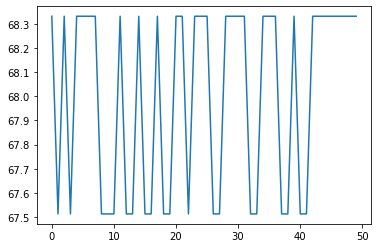

In [22]:
plt.plot(losses)

In [23]:
print(np.mean(losses))
print(np.var(losses))

68.00361356189448
0.16064389991973138


# 4.2 - Spectral Clustering

In [24]:
eigs = np.linalg.eig(laplacian)

In [25]:
eigvec2 = eigs[1][1]

In [26]:
for i in range(len(eigvec2)):
    a = "MATCH(a:Stock {name: '" + corr_mat.index[i] + "'})"
    if eigvec2[i] > 0:
        b = "SET a.Cluster = 1"
    else:
        b = "SET a.Cluster = 2"
        
    graph.run(a+b)

In [27]:
loss_function_sc(graph, corr_mat, 'Cluster', 'Stock')

62.776947657358626

Although this is only a few percentage points below the random solutions, it is meaningfully different from it. Thus, we have clear evidence that the spectral clustering has worked well!

# 5 - More advanced clustering

So far, we only assumed two clusters. However, this is not very realistic. In reality, we would expect there to be many more clusters in a network of 30 than just two. 

As such, we now employ a more sophisticated clustering procedure - k means clustering. 

In [46]:
from sklearn.cluster import KMeans

The clustering is performed in the eigenspace by use of k means clustering, a stochastic procedure. 

In [37]:
km3 = KMeans(n_clusters = 3, random_state=42, max_iter=1000).fit(eigs[1])
km4 = KMeans(n_clusters = 4, random_state=42, max_iter=1000).fit(eigs[1])
km5 = KMeans(n_clusters = 5, random_state=42, max_iter=1000).fit(eigs[1])
km6 = KMeans(n_clusters = 6, random_state=42, max_iter=1000).fit(eigs[1])
km7 = KMeans(n_clusters = 7, random_state=42, max_iter=1000).fit(eigs[1])
km8 = KMeans(n_clusters = 8, random_state=42, max_iter=1000).fit(eigs[1])
km9 = KMeans(n_clusters = 9, random_state=42, max_iter=1000).fit(eigs[1])
km10 = KMeans(n_clusters = 10, random_state=42, max_iter=1000).fit(eigs[1])

In [42]:
kms = [km3, km4, km5, km6, km7, km8, km9, km10]
for elem in kms:
    for i in range(len(corr_mat.index)):
        stock = corr_mat.index[i]
        query = "MATCH (a:Stock {name: '" + str(stock) + "'}) "
        query = query + "SET a.kn" + str(elem.n_clusters) + "= " + str(elem.labels_[i])
        graph.run(query)

In [45]:
for i in range(3,11):
    cl = 'kn' + str(i)
    print(cl + ' ' + str(loss_function_sc(graph, corr_mat, cl, 'Stock')))

kn3 62.66288898750283
kn4 37.65851845606789
kn5 47.13626403540716
kn6 51.84161859406132
kn7 54.15250234320928
kn8 55.23670898471206
kn9 59.61754827473985
kn10 68.7131999625961


Based on this, k-means clustering with 4 different clusters is the best choice, which - based on economic information should actually make sense.

# Done!